In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader 
from torch.autograd import Variable
from torch.backends import cudnn


import matplotlib.pyplot as plt
import os
from PIL import Image
import cv2
import numpy as np


# Augmenting library 

import torchvision
import torchvision.transforms.functional as TF
import albumentations as A
import torchvision.transforms as T

# Control Randomness
import random
random_seed = 7
torch.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

import warnings
warnings.filterwarnings("ignore")
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2, 3"
print(torch.cuda.device_count())


# logging
import datetime
from tensorboardX import SummaryWriter
from tqdm import tqdm
import time 
import warnings
warnings.filterwarnings('ignore')

/home/sklab2/anaconda3/envs/vessel2/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2


In [2]:
import joint_transforms
from config import cod_training_root
from config import backbone_path
from datasets import ImageFolder
from misc import AvgMeter, check_mkdir
from PFNet import PFNet
from helper import *
import loss

# Config

In [3]:
ckpt_path = './ckpt'
exp_name = 'PFNet'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
args = {
    'epoch_num': 300,
    'train_batch_size': 32,
    'last_epoch': 0,
    'lr': 5e-4, 
    'lr_decay': 0.9,
    'weight_decay': 1e-4,
    'momentum': 0.9,
    'snapshot': '',
    'scale': 416, 
    'save_point': [],
    'poly_train': False,
    'optimizer': 'Adam',
    'amp' : False
}

In [4]:
from helper import BinaryFocalLoss, sigmoid_focal_loss
# loss function
structure_loss = loss.structure_loss().to(device)
bce_loss = nn.BCEWithLogitsLoss().to(device)
iou_loss = loss.IOU().to(device)
focal_loss = BinaryFocalLoss(alpha=3, gamma=2, ignore_index=None, reduction='mean')

def bce_iou_loss(pred, target):
    bce_out = bce_loss(pred, target)
    iou_out = iou_loss(pred, target)
    loss = bce_out + iou_out
    return loss

def focal_iou_loss(pred, target):
    focal_out = sigmoid_focal_loss(pred, target, alpha=0.25, reduction='mean')
    iou_out = iou_loss(pred, target)
    loss = focal_out + iou_out
    return loss

# Net

In [5]:
net = PFNet(backbone_path)

From ./backbone/resnet/resnet50-19c8e357.pth Load resnet50 Weights Succeed!


In [6]:
from torch.optim.lr_scheduler import ReduceLROnPlateau



if args['optimizer'] == 'SGD':
    print('SGD opt')
    optimizer = torch.optim.SGD([
        {'params': [param for name, param in net.named_parameters() if name[-4:] == 'bias'],
        'lr': 2 * args['lr']},
        {'params': [param for name, param in net.named_parameters() if name[-4:] != 'bias'],
        'lr': 1 * args['lr'], 'weight_decay': args['weight_decay']}
    ], momentum=args['momentum'])

else:
    print('Adam opt')
    optimizer = torch.optim.Adam([
        {'params': [param for name, param in net.named_parameters() if name[-4:] == 'bias'],
            'lr': 2 * args['lr']},
        {'params': [param for name, param in net.named_parameters() if name[-4:] != 'bias'],
            'lr': 1 * args['lr'], 'weight_decay': args['weight_decay']}
    ])

# scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=20, \
#                                 threshold=0.05, threshold_mode='rel', cooldown=5, min_lr = 1e-4)

scheduler = CosineAnnealingWarmupRestarts(optimizer, first_cycle_steps=50, cycle_mult=1.0, max_lr=1e-3, min_lr=1e-5, warmup_steps=5, gamma=0.8)

Adam opt


## making data index list

In [7]:
mask_files = os.walk("/home/sklab2/workspace/datashared/SS-OCT/vessel_segmentation/masked")
mask_idx = []
for (root, dirs, files) in mask_files:
    if len(files) > 0 :
        mask_idx.append(files)

mask_idxs = [element for array in mask_idx for element in array]
len(mask_idxs)

1691

In [8]:
# 1~ 11 / 12, 13, 14  , 40, 41, 43, 44, 46, 49,  50, 53, 54, 55 
train_indexs = []
test_indexs = []
for idx, data in enumerate(mask_idxs):
    tmp = mask_idxs[idx].split('_')
    if len(tmp) < 3:
        if int(tmp[0]) < 45:
            train_indexs.append([ tmp[0], tmp[1].split('.')[0]])
        else:
            test_indexs.append([tmp[0], tmp[1].split('.')[0]])

In [9]:
len(train_indexs) , len(test_indexs)

(1319, 355)

# Dataloader

In [10]:
import albumentations.augmentations.functional as AF

PATH = '/home/sklab2/workspace/datashared/SS-OCT/vessel_segmentation/'
class VesselDataset(Dataset):
    def __init__(self, index, transforms):
        self.index = index
        self.transforms = transforms
        
    def __len__(self):
        return len(self.index)
        
    def __getitem__(self, idx):
        s_1 = self.index[idx][0]
        s_2 = self.index[idx][1]

        # '1_L_0.jpg', 
        # image = Image.open(PATH+'origin/' + s_1+'_L_'+s_2+'.jpg').convert("L").resize((416, 416),Image.Resampling.BILINEAR)
        image = Image.open(PATH+'origin/' + s_1+'_L_'+s_2+'.jpg').resize((416, 416),Image.Resampling.BILINEAR)
        #'10_L_112_L.png', 
        mask = Image.open(PATH+'masked/' +  s_1+'_'+s_2+'.png').resize((416, 416),Image.Resampling.NEAREST)
        
        image = np.array(image) #RGB
        mask = np.array(mask, dtype=np.uint8)   # HWC
        # mask_o = mask / 255        # CHW
        mask_o = mask.transpose(2, 0, 1)
        lower_red = np.array([-10, 100, 100]) 
        upper_red = np.array([10, 255, 255])

        lower_yellow = np.array([22, 93, 0]) 
        upper_yellow = np.array([45, 255, 255])

        # lower_yellow = np.array([55, 60, 200]) 
        # upper_yellow = np.array([60, 255, 255]) 

        mask_hsv = cv2.cvtColor(mask, cv2.COLOR_RGB2HSV)

        mask_r = cv2.inRange(mask_hsv, lower_red, upper_red)
        mask_y = cv2.inRange(mask_hsv, lower_yellow, upper_yellow)
        # mask_y = 255 - mask_y # 색반전
        mask_r = mask_r/255
        mask_y = mask_y/255

        mask_r = np.clip(mask_r, 0 ,1)
        mask_y = np.clip(mask_y, 0, 1)

        # mask_r = np.expand_dims(mask_r,axis=0)
        # mask_y = np.expand_dims(mask_y,axis=0)

        # mask = np.concatenate([mask_r, mask_y], axis=0)
        masks = [mask_r, mask_y]
        # print(mask.shape)
    
        # aft_mask = cv2.resize(aft_mask, (416, 416), interpolation=cv2.INTER_NEAREST)
        # for num in range(3): #### 3번 이터레이션이 왜들어갔지?
        if self.transforms:
            transformed = self.transforms(image=image, masks=masks)
            image, masks = transformed['image'], transformed['masks']

                    
        return image, masks, mask_o

In [22]:
import albumentations.pytorch as AP

train_transforms = A.Compose([
    A.RandomRotate90(p=0.25),
    A.RandomResizedCrop(416, 416, scale=(0.5, 1.0), ratio=(0.8, 1.2), interpolation=cv2.INTER_AREA, p=0.25),
    A.OneOf([
        A.OpticalDistortion(p=1, interpolation=cv2.INTER_AREA),
        A.GridDistortion(p=1, interpolation=cv2.INTER_AREA),
        A.ElasticTransform(p=1, alpha=100, sigma=100 * 0.05, alpha_affine=100 * 0.03, interpolation=cv2.INTER_AREA)
        ], p = 0.5),  # 밝기 및 조도 변화
    # A.Normalize(mean=(126.71482973095203, 126.6879562017254, 126.85466873988524), std = (32.9434, 33.0122, 32.9186)),
    A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.25),
    AP.ToTensorV2(transpose_mask=False),
    
])

test_transforms = A.Compose([
    AP.ToTensorV2(transpose_mask=False)
])

train_dataset = VesselDataset(index=train_indexs, transforms=train_transforms)
test_dataset = VesselDataset(index=test_indexs, transforms=test_transforms)
 
#train_dataset, _, test_dataset = torch.utils.data.random_split(dataset, [train, 0, test])

train_loader = DataLoader(dataset=train_dataset, batch_size=args['train_batch_size'], shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)

# image, [mask_r, mask_y, mask_o] =next(iter(train_loader))
image,[mask_r, mask_y], mask_o = next(iter(train_loader))
print(image.shape, mask_r.shape, mask_y.shape, mask_o.shape)

torch.Size([32, 3, 416, 416]) torch.Size([32, 416, 416]) torch.Size([32, 416, 416]) torch.Size([32, 3, 416, 416])


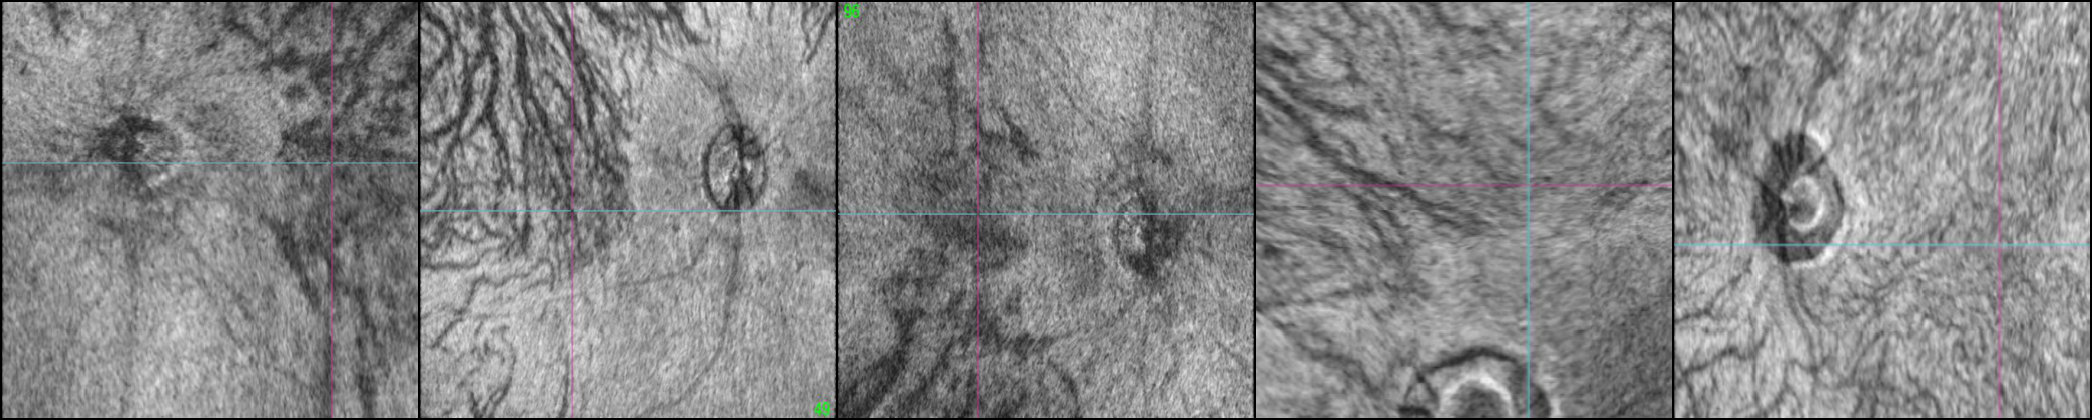

In [23]:
TF.to_pil_image(torchvision.utils.make_grid(image[:5]))

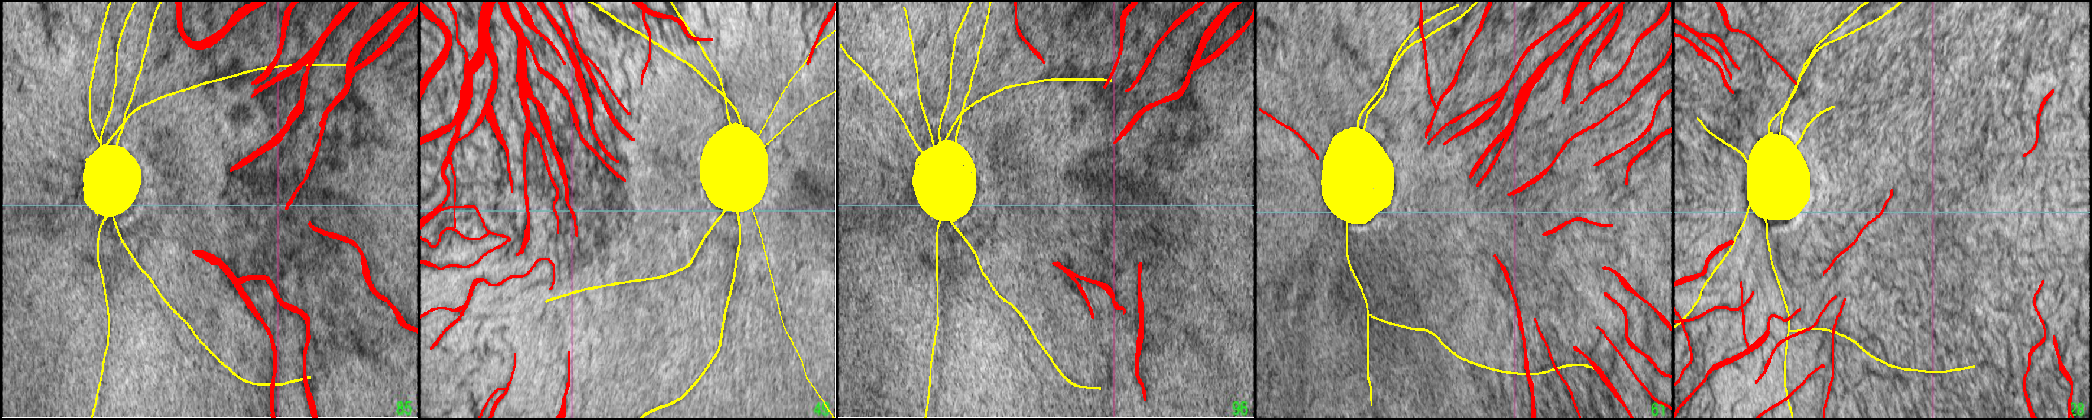

In [24]:
TF.to_pil_image(torchvision.utils.make_grid(mask_o[:5]))

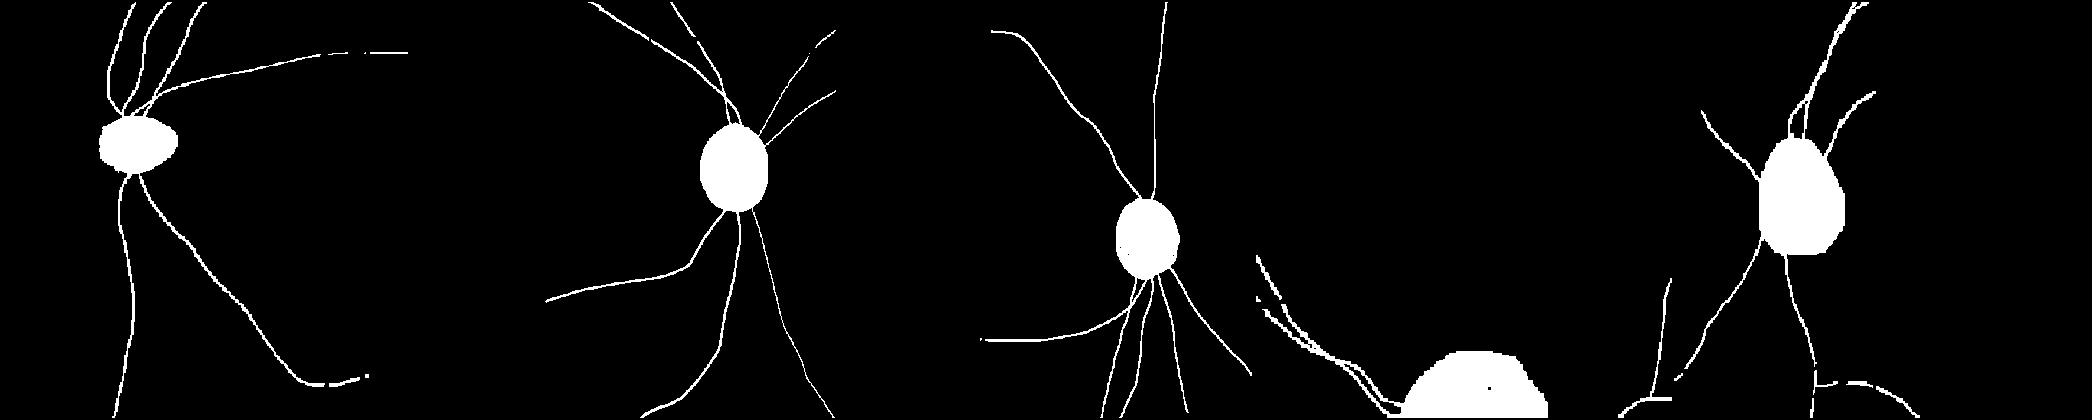

In [25]:
TF.to_pil_image(torchvision.utils.make_grid(mask_y[:5].unsqueeze(-3).expand(5, 3, 416, 416).type(torch.float)))

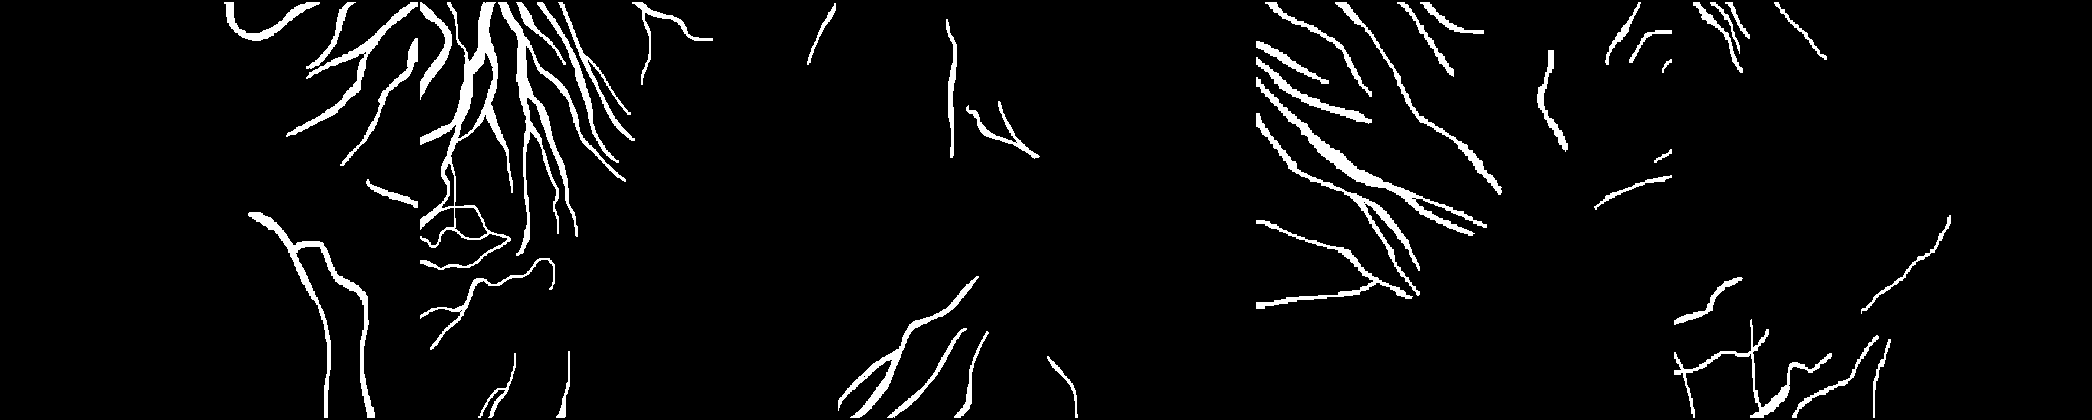

In [26]:
TF.to_pil_image(torchvision.utils.make_grid(mask_r[:5].unsqueeze(-3).expand(5, 3, 416, 416).type(torch.float)))

In [16]:
from sklearn.metrics import jaccard_score, precision_score, recall_score
def calc_metric(labels, preds):
    accuracy = np.mean(np.equal(labels,preds))
    right = np.sum(labels *preds == 1)
    precision = right / np.sum(preds)
    recall = right / np.sum(labels)
    f1 = 2 * precision*recall/(precision+recall)

    
    y_pred = preds
    y_true = labels
    """ Ground truth """
    #y_true = y_true.cpu().numpy()
    y_true = y_true > 0.5
    y_true = y_true.astype(np.uint8)
    y_true = y_true.reshape(-1)

    """ Prediction """
    #y_pred = y_pred.cpu().numpy()
    y_pred = y_pred > 0.5
    y_pred = y_pred.astype(np.uint8)
    y_pred = y_pred.reshape(-1)

    score_jaccard = jaccard_score(y_true, y_pred)

    print('jaccard, f1, recall, precision, acc')
    print(score_jaccard, f1, recall, precision, accuracy)
    return score_jaccard, f1, recall, precision, accuracy

# Train

In [17]:
from tensorboardX import SummaryWriter
import datetime 

exp = 'aug50+focal+coslr'

num_epochs = args['epoch_num']
resume_epochs = args['last_epoch']
load_from = '../model/vessel_PFNet_base_b32_e500_220921_00:30.pt'


batch_size = args['train_batch_size']
now = datetime.datetime.now()
log_name = f'{exp}_b{batch_size}_e{num_epochs}_js_'+now.strftime("%y%m%d_%H:%M")
writer = SummaryWriter(log_dir='./ckpt/PFNet/log/'+ log_name)
save_path = f'../model/vessel_PFNet_{exp}_b{batch_size}_e{num_epochs}_'+ now.strftime("%y%m%d_%H:%M") + '.pt'

if torch.cuda.device_count() > 1:
    print(f'Using {torch.cuda.device_count()} GPUs.')
net = nn.DataParallel(net)

# net.float()
net = net.to(device)
train_loss_list = []
test_acc_list = []
test_recall_list = []
test_f1_list = []
test_miou_list = []
print(log_name)
print(save_path)
print(f'Training {num_epochs} epochs.')
if resume_epochs != 0:
    print(f'Resuming from epoch {resume_epochs}')
    net.load_state_dict(torch.load(load_from))
if args['amp'] == True:
    print("Using mixed precision.")

# print(data.shape, aug_masks[0].shape, aug_masks[1].shape, aft_mask.shape)
curr_iter = 1

for epoch in range(args['last_epoch'], args['last_epoch'] + args['epoch_num']):
    
    net.train()

    loss_running = 0
    tqdm_dataset = tqdm(train_loader)
    for batch_idx, batch in enumerate(tqdm_dataset):
        if args['poly_train']:
            base_lr = args['lr'] * (1 - float(curr_iter) / float(num_epochs)) ** args['lr_decay']
            optimizer.param_groups[0]['lr'] = 2 * base_lr
            optimizer.param_groups[1]['lr'] = 1 * base_lr

        image,[mask_r, mask_y], _ = batch
        image = image.float().to(device)
        label = mask_r.unsqueeze(1).float().to(device)
        optimizer.zero_grad()

        predict_1, predict_2, predict_3, predict_4 = net(image)

        loss_1 = focal_iou_loss(predict_1, label)
        loss_2 = structure_loss(predict_2, label)
        loss_3 = structure_loss(predict_3, label)
        loss_4 = structure_loss(predict_4, label)
        loss = 1 * loss_1 + 1 * loss_2 + 2 * loss_3 + 4 * loss_4
        
        loss.backward()
        # nn.utils.clip_grad_norm_(net.parameters(), max_norm=10)
        optimizer.step()
        
        loss_running += loss.item()
        
        tqdm_dataset.set_postfix({
            'Epoch': epoch,
            'Loss': '{:06f}'.format(loss.item()),
            'Mean Loss' : '{:06f}'.format(loss_running/(batch_idx+1)),
            'lr' : '{:06f}'.format(optimizer.param_groups[0]["lr"])
        })

        curr_iter += 1

    epoch_loss = loss_running / len(train_loader)
    scheduler.step()
    writer.add_scalar('loss/Train', epoch_loss, epoch)
    writer.add_scalar('learning_rate', optimizer.param_groups[0]["lr"], epoch)
    train_loss_list.append(epoch_loss)

## EVAL
    if epoch % 5 == 0 or epoch == args['epoch_num']-1 :
        print("Testing...")

        images=[]
        preds=[]
        labels=[]
        label_os = []
    
        net.eval()
        # tqdm_loader = tqdm(test_loader)
        with torch.no_grad():
            running_loss = 0
            for idx, batch in enumerate(tqdm(test_loader)):

                image, masks, mask_o = batch 
                
                image,[mask_r, mask_y], label_o = batch
                image = image.float().to(device)
                label = mask_r.unsqueeze(1).float().to(device)
                predict_1, predict_2, predict_3, predict_4 = net(image)

                loss_1 = focal_iou_loss(predict_1, label)
                loss_2 = structure_loss(predict_2, label)
                loss_3 = structure_loss(predict_3, label)
                loss_4 = structure_loss(predict_4, label)
                loss = 1 * loss_1 + 1 * loss_2 + 2 * loss_3 + 4 * loss_4    
                running_loss += loss.item()

                images.append(image.cpu().detach().numpy())
                labels.append(label.cpu().detach().numpy())
                label_os.append(label_o)
                preds.append(predict_1.cpu().detach().numpy())

            images= np.array(images).squeeze(1)
            preds = np.array(preds).squeeze(1)
            labels = np.array(labels).squeeze(1)
            label_os = np.array(label_os)
            preds = np.where(preds > 0.5 , 1 , 0)
            labels = np.where(labels > 0.5 , 1 , 0)
            epoch_loss = loss_running / len(test_loader)
            
            score_jaccard, score_f1, score_recall, score_precision, score_acc = calc_metric(labels=labels, preds=preds)
            test_acc_list.append(score_acc)
            test_recall_list.append(score_recall)
            test_f1_list.append(score_f1)
            test_miou_list.append(score_jaccard)
            writer.add_scalar('Loss/Test', epoch_loss, epoch)
            writer.add_scalar('Accuracy/Test', score_acc, epoch)
            writer.add_scalar('F1/Test', score_f1, epoch)
            writer.add_scalar('Recall/Test', score_recall, epoch)
            writer.add_scalar('Precision/Test', score_precision, epoch)
            writer.add_scalar('Jaccard/Test', score_jaccard, epoch)

            if np.max(test_miou_list) == test_miou_list[-1]:
                torch.save(net.state_dict(), save_path)
                print("Model Saved")

            randnum = np.random.randint(0, 355)
            plt.figure(figsize=(10, 4))
            plt.subplot(1, 3, 1)
            plt.imshow(label_os[randnum][0].permute(1, 2, 0))
            plt.axis('off')
            plt.subplot(1, 3, 2)  
            plt.imshow(labels[randnum][0])
            plt.axis('off')
            plt.subplot(1, 3, 3)
            plt.imshow(preds[randnum][0])
            plt.axis('off')
            plt.tight_layout()
            plt.show()

Using 2 GPUs.
aug50+focal+coslr_b32_e300_js_221007_05:06
../model/vessel_PFNet_aug50+focal+coslr_b32_e300_221007_05:06.pt
Training 300 epochs.


  0%|          | 0/42 [00:06<?, ?it/s]


RuntimeError: grad can be implicitly created only for scalar outputs

In [ ]:
# label_os.shape, preds.shape, labels.shape

((355,), (355, 1, 416, 416), (355, 1, 416, 416))

In [ ]:
preds.shape

# evaluation

In [ ]:
print("Testing...")
net = PFNet(backbone_path)
load_from = '../model/vessel_PFNet_aug50+focal+coslr_b32_e300_220928_01:55.pt'
if torch.cuda.device_count() > 1:
    print(f'Using {torch.cuda.device_count()} GPUs.')
    net = nn.DataParallel(net)
# load_from
net = nn.DataParallel(net)
net.load_state_dict(torch.load(load_from))
net.to(device)

images=[]
preds=[]
labels=[]
label_os = []
urls_list = []
net.eval()
# tqdm_loader = tqdm(test_loader)
with torch.no_grad():
    for idx, dd in enumerate(tqdm(test_loader)):

        image, masks, mask_o, urls = dd 
        
        image = image.float().to(device)
        label = masks[0].float()
        label_o = masks[1].float()
        _, _, _, pred = net(image)    

        images.append(image.cpu().detach().numpy())
        labels.append(label.numpy())
        label_os.append(label_o)
        preds.append(pred.cpu().detach().numpy())
        urls_list.append(urls)

    images= np.array(images).squeeze(1)
    preds = np.array(preds).squeeze(1)
    labels = np.array(labels)
    label_os = np.array(label_os)
    preds = np.where(preds > 0.5 , 1 , 0)
    labels = np.where(labels > 0.5 , 1 , 0)
    
    score_jaccard, score_f1, score_recall, score_precision, score_acc = calc_metric(labels=labels, preds=preds)

In [ ]:
# randnum = np.random.randint(0, len(test_dataset)-10)
randnum=211

fig, axes = plt.subplots(10, 3, figsize = (10,40))
[c_ax.axis('off') for c_ax in axes.flatten()]

for idx, (img_ax, target_ax , mask_ax ) in zip(range(randnum, randnum+10), axes):
    
# inputs[:10] , preds[:10], targets[:10], urls_list[:10]) :
    
    image = images[idx].astype(int).transpose(1, 2, 0) # astype(int)
    img_target = preds[idx].transpose(1, 2, 0) 
    img_mask = labels[idx].transpose(1, 2, 0)  
 
    img_ax.imshow(np.clip(image, 0, 255))

    target_ax.imshow(img_target )
    mask_ax.imshow(img_mask)

    img_ax.set_title(f'  testing: {idx}')
    target_ax.set_title(f' Predicted : {idx}')
    
    mask_ax.set_title(f' target   vessel: {idx}')
plt.tight_layout()
plt.show()